## A sniplet generating data simulating a high throughput expression analysis experiment

In [997]:
import numpy as np
import numpy.random as npr
import pandas as pd

def generate_expression_data(n_analytes=100, n_samples=2, n_replicates=3, p_regulated=0.2, mean_offset=3.0, var=0.2, diff_var=2.0):
    # Here we follow a convension, The first sample is the reference i.e. have all label 1
    labels = npr.binomial(1, p_regulated, (n_analytes,n_samples-1))
    template = np.hstack((np.zeros((n_analytes,1)),labels))
    
    # We expand the template labels into several replicates
    regulated = np.repeat(template,n_replicates, axis=1)
    
    # If the reading is regulated, offset it with a random offset sampled from the normal distribution 
    offset = regulated*npr.normal(0,diff_var,(n_analytes,1))
    
    # Model a differentexpression level for the different analytes
    expr_level = np.ones((n_analytes,n_samples*n_replicates))*npr.normal(mean_offset,mean_offset,(n_analytes,1))
    
    # add noice for each measurement
    expression = npr.normal(offset+expr_level,var,(n_analytes,n_replicates*n_samples))
    expression = 2**expression
    
    analyte_names = ["a"+str(i+1) for i in range(n_analytes)]
    sample_names = ["s"+str(i+1)+'_'+str(j+1) for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe for expression values
    expr_df = pd.DataFrame(expression,columns=sample_names,index=analyte_names)
    expr_df.loc["Sample",:] = [i+1 for i in range(n_samples) for j in range(n_replicates)]
    
    # Create a dataframe with answers if the reading was modeled as differential or not
    label_df = pd.DataFrame(template,columns=[i+1 for i in range(n_samples)],index=analyte_names)
                
    return expr_df,label_df

In [1077]:
dat = generate_expression_data(n_analytes=10000)
data_labels = dat[1][:]
data = dat[0][:-1]

In [1088]:
pval_plur = []

# Generate p-values through t-test
for i in range(0, data.shape[0]):
    pval_plur.append(scistat.ttest_ind(data.iloc[i, :3], data.iloc[i, 3:])[1])

# Number of p-values
m = len(pval_plur)

# Create an array with tuples of index and value from pval_plur
pval_plur = [[x, y] for x, y in sorted(enumerate(pval_plur))]
pval_plur = np.array(pval_plur)

# Sort after p-values, smallest to largest
pval_plur = pval_plur[np.argsort(pval_plur[:, 1])]

# Set our lambda and t
lambd = 0.5
t = 0.05

# Count how many p-values are greater than our lambda
i = 0
for j in range(0, len(pval_plur)):
    if pval_plur[j][1] > lambd:
        i += 1
    else:
        next
lambda_count = i

# Calculate our Pi_0 and Q_P_i(m)
pi_zero = lambda_count/(m*(1-lambd))
qpim = pi_zero*pval_plur[-1][1]

#qpii = [[1000, qpim]]
qpii = []

# generate q-values iterating over the ordered p-value-indexes from pval_plur
for i in reversed(range(1, len(pval_plur)+1)):
    if i == len(pval_plur):
        qval = min(((pi_zero*pval_plur[i-1][1]*m)/i), pi_zero*pval_plur[i-2][1])
    else:
        qval = min(((pi_zero*pval_plur[i-1][1]*m)/i), pi_zero*pval_plur[i][1])
        
    qpii.append([pval_plur[i-1][0], qval])

qpii = np.array(qpii)
#qvals = np.array(qpii[::-1])

qvals = qpii[np.argsort(qpii[:,0])]

#put them together before cumsum

df = pd.DataFrame({'q':qvals[:,1], 'labs':data_labels.iloc[:,1]})

df = df.sort_values(by='q')

null = np.cumsum(1-df.iloc[:,0])/range(1, len(df.iloc[:,0])+1)
df['null'] = null


del df['labs']

In [554]:
df.loc[df.iloc[:,0]>2000].index

Index([], dtype='object')

In [1089]:
df

,q,null
a2736,2.410360e-08,0.000000
a3511,2.498961e-08,0.000000
a6792,3.507146e-08,0.000000
a1016,3.806942e-08,0.000000
a122,3.833578e-08,0.000000
a4851,5.849645e-08,0.000000
a4958,7.857197e-08,0.000000
a2077,9.915758e-08,0.000000
a9606,1.379168e-07,0.000000
a8033,2.542311e-07,0.000000


In [446]:
df.loc[df['q']==2278].index

Index(['a2'], dtype='object')

#### 5. Plot the (simulated) number of differential expression genes as a function of q-value threshold.

([array([ 1000.,  1000.,  1000.,  1000.,  1000.,  1000.,  1000.,  1000.,
          1000.,  1000.]),
  array([ 10000.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,      0.])],
 array([    0. ,   999.9,  1999.8,  2999.7,  3999.6,  4999.5,  5999.4,
         6999.3,  7999.2,  8999.1,  9999. ]),
 <a list of 2 Lists of Patches objects>)

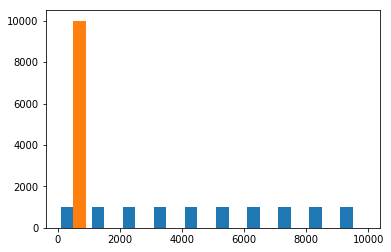

In [1086]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.hist(qvals)

###### 6. Plot the difference between q-values and the actual fraction of null statistics (using the labels from the generator).

Text(0.5,1,'Q-values vs fraction of null statistics')

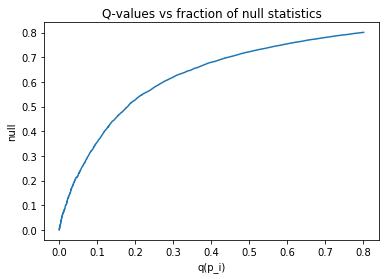

In [1085]:
%matplotlib inline
from matplotlib import pyplot as plt
from pylab import *

# True positives in data
(data_labels.iloc[:,1] == 1).describe()[3]

# plt.plot(q_of_pi_zero, cumsum(1-data_labels.iloc[:,1])/range(1, len(data_labels)+1))
plt.plot(df.iloc[:,0], df.iloc[:,1])
plt.xlabel("q(p_i)")
plt.ylabel("null")
plt.title("Q-values vs fraction of null statistics")